# Tarefa 4 - Recompensa Média Softmax Ator-Crítico

Bem-vindo à tarefa de programação 4 do curso 3. Nesta tarefa, você implementará **Recompensa média Softmax ator-crítico** no problema de oscilação do pêndulo que você viu anteriormente na palestra. Através desta tarefa, você obterá experiência prática na implementação de métodos de ator-crítico em uma tarefa contínua.

**Nesta tarefa, você irá:**
 1. Implementar agente ator-crítico softmax em uma tarefa contínua usando a formulação de recompensa média.
 2. Compreender como parametrizar a política como função de aprendizagem, num ambiente de ação discreto.
 3. Compreender como amostrar (aproximadamente) o gradiente deste objetivo para atualizar o ator.
 4. Entenda como atualizar o crítico usando erro diferencial de TD.


## Ambiente de oscilação do pêndulo

Neste trabalho usaremos um ambiente Pendulum, adaptado de [Santamaría et al. (1998)](http://www.incompleteideas.net/papers/SSR-98.pdf). Este também é o mesmo ambiente que usamos na palestra. O diagrama abaixo ilustra o ambiente.

<img src="data/pendulum_env.png" alt="Desenho" style="largura: 400px;"/>

O ambiente consiste em um único pêndulo que pode girar 360 graus. O pêndulo é acionado aplicando um torque em seu ponto de articulação. O objetivo é fazer com que o pêndulo se equilibre para cima e para a direita a partir de sua posição de repouso (pendurado na parte inferior sem velocidade) e mantê-lo o maior tempo possível. O pêndulo pode mover-se livremente, sujeito apenas à gravidade e à ação aplicada pelo agente.

O estado é bidimensional, que consiste no ângulo atual $\beta \in [-\pi, \pi]$ (ângulo da posição vertical vertical) e na velocidade angular atual $\dot{\beta} \in (- 2\pi, 2\pi)$. A velocidade angular é restrita para evitar danos ao sistema de pêndulo. Se a velocidade angular atingir este limite durante a simulação, o pêndulo é redefinido para a posição de repouso.
A ação é a aceleração angular, com valores discretos $a \in \{-1, 0, 1\}$ aplicados ao pêndulo.
Para mais detalhes sobre a dinâmica ambiental você pode consultar o artigo original.

O objetivo é balançar o pêndulo e manter seu ângulo vertical. Portanto, a recompensa é o ângulo absoluto negativo da posição vertical: $R_{t} = -|\beta_{t}|$

Além disso, como o objetivo é alcançar e manter uma posição vertical, não há términos nem episódios. Assim, este problema pode ser formulado como uma tarefa contínua.

Semelhante à tarefa do Mountain Car, a ação neste ambiente de pêndulo não é forte o suficiente para mover o pêndulo diretamente para a posição desejada. O agente deve aprender primeiro a mover o pêndulo para longe da posição desejada e ganhar impulso suficiente para balançar o pêndulo com sucesso. E mesmo depois de atingir a posição vertical o agente deve aprender a equilibrar continuamente o pêndulo nesta posição instável.

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html) : Library for reinforcement learning experiments.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments
- plot_script : custom script to plot results
- [tiles3](http://incompleteideas.net/tiles/tiles3.html) : A package that implements tile-coding.
- pendulum_env : Pendulum Swing-up Environment

**Please do not import other libraries** — this will break the autograder.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import itertools
from tqdm import tqdm

from rl_glue import RLGlue # type: ignore
from pendulum_env import PendulumEnvironment # type: ignore
from agent import BaseAgent # type: ignore
import plot_script # type: ignore
import tiles3 as tc  # type: ignore

## Seção 1: Criar função auxiliar de codificação de bloco

Nesta seção, construiremos uma classe de codificação de blocos para nosso agente que tornará mais fácil fazer chamadas para nosso codificador de blocos.

A codificação em blocos é introduzida na Seção 9.5.4 do livro como uma forma de criar recursos que podem fornecer boa generalização e discriminação. Já o usamos em nossa última tarefa de programação também.

Semelhante à última tarefa de programação, faremos uma função específica para codificação de blocos para nosso ambiente Pendulum Swing-up. Também usaremos a [biblioteca Tiles3](http://incompleteideas.net/tiles/tiles3.html).

Para fazer o codificador de blocos funcionar, precisamos:

    1) crie uma tabela hash de índice usando tc.IHT(),
    2) dimensionar as entradas para o codificador de blocos com base no número de blocos e no intervalo de valores que cada entrada pode assumir
    3) ligue para tc.tileswrap para recuperar os blocos ativos.

No entanto, precisamos fazer uma pequena alteração neste codificador de blocos.
Observe que neste ambiente o espaço de estados contém ângulo, que está entre $[-\pi, \pi]$. Se codificarmos este espaço de estados da maneira usual, o agente pode pensar que o valor dos estados corresponde a um ângulo de $-\pi$ é muito diferente do ângulo de $\pi$ quando na verdade eles são iguais! Para remediar isso e permitir a generalização entre ângulo $= -\pi$ e ângulo $= \pi$, precisamos usar **codificador de bloco wrap**.

O uso do codificador de ladrilho envolvente é quase idêntico ao codificador de ladrilho original, exceto que também precisamos fornecer o argumento `wrapwidth` para a dimensão que queremos envolver (portanto, apenas para ângulo e `None` para velocidade angular). Mais detalhes sobre o codificador de blocos envolventes também são fornecidos na [biblioteca Tiles3](http://incompleteideas.net/tiles/tiles3.html).


In [ ]:
class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Inicializa o codificador de blocos MountainCar
        Inicializadores:
        iht_size -- int, o tamanho da tabela hash do índice, normalmente uma potência de 2
        num_tilings -- int, o número de ladrilhos
        num_tiles -- int, o número de peças. Aqui a largura e a altura dos ladrilhos são iguais

        Variáveis ​​de classe:
        self.iht -- tc.IHT, a tabela hash de índice que o codificador de blocos usará
        self.num_tilings -- int, o número de ladrilhos que o codificador de ladrilho usará
        self.num_tiles -- int, o número de blocos que o codificador de blocos usará
        """

        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.iht = tc.IHT(iht_size)

    def get_tiles(self, angle, ang_vel):
      """

      Captura um ângulo e uma velocidade angular do ambiente do pêndulo
      e retorna uma matriz numpy de blocos ativos.

      Argumentos:
      angle - float, o ângulo do pêndulo entre -np.pi e np.pi
      ang_vel -- float, a velocidade angular do agente entre -2*np.pi e 2*np.pi

      Retorna:
      blocos - np.array, blocos ativos
      """

      # Dimensione o ângulo e a velocidade angular entre [0, 1]
      # em seguida, multiplique pelo número de blocos para que eles estejam entre [0, self.num_tiles]
      angle_scaled = (angle + np.pi) / (2 * np.pi) * self.num_tiles
      ang_vel_scaled = (ang_vel + 2 * np.pi) / (4 * np.pi) * self.num_tiles

      # Obtenha os blocos chamando o método tc.tileswrap
      # wrapwidths especifica qual dimensão envolver e sua largura de encapsulamento
      tiles = tc.tileswrap(self.iht, self.num_tilings, [angle_scaled, ang_vel_scaled], wrapwidths=[self.num_tiles, False])

      return np.array(tiles)

Run the following code to verify `PendulumTilecoder`

In [ ]:
## Test Code for PendulumTileCoder ##
# Your tile coder should also work for other num. tilings and num. tiles
angles = np.linspace(-np.pi, np.pi, num=5)
vels = np.linspace(-2 * np.pi, 2 * np.pi, num=5)
test_obs = list(itertools.product(angles, vels))

pdtc = PendulumTileCoder(iht_size=4096, num_tilings=8, num_tiles=2)

result=[]
for obs in test_obs:
    angle, ang_vel = obs
    tiles = pdtc.get_tiles(angle=angle, ang_vel=ang_vel)
    result.append(tiles)

expected = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 8, 3, 9, 10, 6, 11],
    [12, 13, 8, 14, 9, 10, 15, 11],
    [12, 13, 16, 14, 17, 18, 15, 19],
    [20, 21, 16, 22, 17, 18, 23, 19],
    [0, 1, 2, 3, 24, 25, 26, 27],
    [0, 1, 8, 3, 28, 29, 26, 30],
    [12, 13, 8, 14, 28, 29, 31, 30],
    [12, 13, 16, 14, 32, 33, 31, 34],
    [20, 21, 16, 22, 32, 33, 35, 34],
    [36, 37, 38, 39, 24, 25, 26, 27],
    [36, 37, 40, 39, 28, 29, 26, 30],
    [41, 42, 40, 43, 28, 29, 31, 30],
    [41, 42, 44, 43, 32, 33, 31, 34],
    [45, 46, 44, 47, 32, 33, 35, 34],
    [36, 37, 38, 39, 4, 5, 6, 7],
    [36, 37, 40, 39, 9, 10, 6, 11],
    [41, 42, 40, 43, 9, 10, 15, 11],
    [41, 42, 44, 43, 17, 18, 15, 19],
    [45, 46, 44, 47, 17, 18, 23, 19],
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 8, 3, 9, 10, 6, 11],
    [12, 13, 8, 14, 9, 10, 15, 11],
    [12, 13, 16, 14, 17, 18, 15, 19],
    [20, 21, 16, 22, 17, 18, 23, 19],
])

assert np.all(expected == np.array(result))

## Seção 2: Criar Recompensa Média Agente Ator-Crítico Softmax

Agora que implementamos o PendulumTileCoder vamos criar o agente que interage com o ambiente. Implementaremos o mesmo algoritmo de recompensa média Ator-Crítico apresentado nos vídeos.

Este agente tem dois componentes: um Ator e um Crítico. O Ator aprende uma política parametrizada enquanto o Crítico aprende uma função de valor de estado. O ambiente possui ações discretas; sua implementação de ator usará uma política softmax com preferências de ação exponenciais. O Ator aprende com a estimativa baseada em amostra para o gradiente do objetivo de recompensa médio. O Crítico aprende usando a versão de recompensa média do algoritmo TD(0) semigradiente.

Nesta seção, você implementará `agent_policy`, `agent_start`, `agent_step` e `agent_end`.

## Seção 2-1: Implementar funções auxiliares

Vamos primeiro definir algumas funções auxiliares úteis.

## Seção 2-1a: Calcular a probabilidade Softmax

Nesta parte você implementará `compute_softmax_prob`.

Esta função calcula a probabilidade softmax para todas as ações, dados os pesos do ator `actor_w` e os blocos ativos `tiles`. Esta função será usada posteriormente em `agent_policy` para provar a ação apropriada.

Primeiro, lembre-se de como a política softmax é representada a partir das preferências de ação do estado: $\large \pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}}$.

**preferência de ação de estado** é definida como $h(s,a, \mathbf{\theta}) \doteq \mathbf{\theta}^T \mathbf{x}_h(s,a)$.

Dados os blocos ativos `tiles` para o estado `s`, preferência de ação de estado $\mathbf{\theta}^T \mathbf{x}_h(s,a)$ pode ser calculado por `actor_w[a][tiles].sum()`.

Também usaremos o **truque exp-normalize**, para evitar possível overflow numérico.
Considere o seguinte:

$\large \pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}} = \frac{e^{h(s,a,\mathbf{\theta}) - c} e^c}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c} e^c} = \frac{e^{h(s,a,\mathbf{\theta}) - c}}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c}}$

$\pi(\cdot|s, \mathbf{\theta})$ é invariante ao deslocamento, e a política permanece a mesma quando subtraímos uma constante $c \in \mathbb{R}$ das preferências de ação do estado.

Normalmente usamos $c = \max_b h(s,b, \mathbf{\theta})$, para evitar qualquer estouro devido à exponenciação de grandes números.

In [ ]:
def compute_softmax_prob(actor_w, tiles):
    """
    Calcula a probabilidade softmax para todas as ações

    Argumentos:
    actor_w - np.array, uma matriz de pesos de atores
    blocos - np.array, uma matriz de blocos ativos

    Retorna:
    softmax_prob - np.array, um array de tamanho igual a num. ações e soma 1.
    """

    # Primeiro calcule a lista de preferências de ação de estado (1 a 2 linhas)
    # state_action_preferences=? (lista de tamanho 3)
    state_action_preferences = [actor_w[a][tiles].sum() for a in range(actor_w.shape[0])]

    # Defina a constante c encontrando o máximo das preferências de ação de estado (usando np.max)
    c = np.max(state_action_preferences)

    # Calcule o numerador subtraindo c das preferências de ação de estado e exponenciando-o (use np.exp) (1 linha)
    numerador = np.exp(state_action_preferences - c)

    # Em seguida, calcule o denominador somando os valores no numerador (use np.sum) (1 linha)
    denominator = np.sum(numerador)

    # Finalmente, divida o numerador pelo denominador e retorne o resultado (1 linha)
    # Crie um array de probabilidade dividindo cada elemento no array numerador pelo denominador
    softmax_prob = np.array(numerador / denominator)

    return softmax_prob

Execute o código a seguir para verificar `compute_softmax_prob`.

Testaremos o método construindo uma política softmax a partir das preferências de ação do estado [-1,1,2].

A probabilidade de amostragem deve então corresponder aproximadamente $[\frac{e^{-1}}{e^{-1}+e^1+e^2}, \frac{e^{1}}{e^{-1}+e^1+e^2}, \frac{e^2}{e^{-1}+e^1+e^2}] \approx$ [0.0351, 0.2595, 0.7054]

In [ ]:
# set tile-coder
iht_size = 4096
num_tilings = 8
num_tiles = 8
test_tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

num_actions = 3
actions = list(range(num_actions))
actor_w = np.zeros((len(actions), iht_size))

# setting actor weights such that state-action preferences are always [-1, 1, 2]
actor_w[0] = -1./num_tilings
actor_w[1] = 1./num_tilings
actor_w[2] = 2./num_tilings

# obtain active_tiles from state
state = [-np.pi, 0.]
angle, ang_vel = state
active_tiles = test_tc.get_tiles(angle, ang_vel)

# compute softmax probability
softmax_prob = compute_softmax_prob(actor_w, active_tiles)
print('softmax probability: {}'.format(softmax_prob))

assert np.allclose(softmax_prob, [0.03511903, 0.25949646, 0.70538451])

softmax probability: [0.03511903 0.25949646 0.70538451]


## Section 2-2: Implement Agent Methods

Vamos primeiro definir os métodos que inicializam o agente. `agent_init()` inicializa todas as variáveis ​​​​que o agente precisará.

Agora que implementamos funções auxiliares, vamos criar um agente. Nesta parte, você implementará `agent_start()` e `agent_step()`. Não precisamos implementar `agent_end()` porque não há encerramento em nossa tarefa contínua.

`compute_softmax_prob()` é usado em `agent_policy()`, que por sua vez será usado em `agent_start()` e `agent_step()`. Implementamos `agent_policy()` para você.

Ao realizar atualizações no Ator e no Crítico, lembre-se de suas respectivas atualizações no vídeo do algoritmo Ator-Crítico.

Aproximamos $q_\pi$ na atualização do Ator usando retorno inicializado em uma etapa ($R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w})$) subtraído pelo valor do estado atual ($\hat{v}(S_{t}, \mathbf{w})$), equivalente ao erro TD $\delta$.

$\delta_t = R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_{t}, \mathbf{w}) \hspace{6em} (1)$

**Regra de atualização da recompensa média**: $\bar{R} \leftarrow \bar{R} + \alpha^{\bar{R}}\delta \hspace{4.3em} (2)$

**Regra de atualização de peso crítico**: $\mathbf{w} \leftarrow \mathbf{w} + \alpha^{\mathbf{w}}\delta\nabla \hat{v}(s,\mathbf{w}) \hspace{2.5em} (3)$

**Actor weight update rule**: $\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha^{\mathbf{\theta}}\delta\nabla ln \pi(A|S,\mathbf{\theta}) \hspace{1.4em} (4)$


No entanto, como estamos usando aproximação de função linear e parametrizando uma política softmax, a regra de atualização acima pode ser ainda mais simplificada usando:

$\nabla \hat{v}(s,\mathbf{w}) = \mathbf{x}(s) \hspace{14.2em} (5)$

$\nabla ln \pi(A|S,\mathbf{\theta}) = \mathbf{x}_h(s,a) - \sum_b \pi(b|s, \mathbf{\theta})\mathbf{x}_h(s,b) \hspace{3.3em} (6)$


In [ ]:
class ActorCriticSoftmaxAgent(BaseAgent):
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_w = None

        self.actions = None

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None

    def agent_init(self, agent_info={}):
        """Configuração do agente chamado quando o experimento é iniciado.

        Defina os parâmetros necessários para configurar o agente de agregação de estado TD(0) semigradiente.

        Suponha que o ditado agent_info contenha:
        {
            "iht_size": int,
            "num_tilings": int,
            "num_tiles": int,
            "actor_step_size": float,
            "critic_step_size": float,
            "avg_reward_step_size": float,
            "num_actions": int,
            "seed": int
        }
        """

        # definir sementes aleatórias para cada execução
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        # inicialize self.tc para o codificador de bloco que criamos
        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        ## defina o tamanho do passo de acordo (normalmente dividimos o tamanho
        # do passo do ator e do crítico por num. tilings (p.217-218 do livro))
        self.actor_step_size = agent_info.get("actor_step_size") / num_tilings
        self.critic_step_size = agent_info.get("critic_step_size") / num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.actions = list(range(agent_info.get("num_actions")))

        # Inicialize a recompensa média como escalar
        self.avg_reward = 0.0

        # Inicialize os pesos dos atores para três vezes o iht_size.
        self.actor_w = np.zeros((len(self.actions), iht_size))

        # Inicialize os pesos críticos
        self.critic_w = np.zeros(iht_size)

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None

    def agent_policy(self, active_tiles):
        """ política do agente
        Args:
        active_tiles (matriz Numpy): blocos ativos retornados pelo codificador de blocos

        Returns:
        A ação selecionada de acordo com a política
        """

        # calcule probabilidade softmax
        softmax_prob = compute_softmax_prob(self.actor_w, active_tiles)

        # Exemplo de ação da matriz de probabilidade softmax
        # self.rand_generator.choice() seleciona um elemento do array com a probabilidade especificada
        chosen_action = self.rand_generator.choice(self.actions, p=softmax_prob)

        # salve softmax_prob pois será útil posteriormente ao atualizar o Ator
        self.softmax_prob = softmax_prob

        return chosen_action

    def agent_start(self, state):
        """O primeiro método chamado quando o experimento começa, chamado após
        o ambiente começa
        Args:
          state (matriz Numpy): o estado da função env_start do ambiente
        Returns:
          A primeira ação que o agente realiza
        """

        angle, ang_vel = state

        ### Use self.tc para obter active_tiles usando angle e ang_vel (2 lines)
        # set current_action by calling self.agent_policy with active_tiles
        active_tiles = self.tc.get_tiles(angle, ang_vel)
        current_action = self.agent_policy(active_tiles)

        self.last_action = current_action
        self.prev_tiles = np.copy(active_tiles)

        return self.last_action

    def agent_step(self, reward, state):
        """Um passo dado pelo agente.
        Args:
          reward (float): a recompensa recebida pela última ação realizada
          state (matriz Numpy): o estado da etapa do ambiente com base em
          onde o agente foi parar depois do
          último passo.
        Returns:
          A ação que o agente está realizando.
        """

        angle, ang_vel = state

        ### Use self.tc to get active_tiles using angle and ang_vel (1 line)
        active_tiles = self.tc.get_tiles(angle, ang_vel)

        ### Calcular delta usando equação (1) (1 line)
        # delta = (reward - self.avg_reward + self.critic_w[active_tiles].sum() - self.critic_w[self.prev_tiles].sum()) +
        # (self.critic_w[active_tiles].sum() - self.critic_w[self.prev_tiles].sum())
        delta = reward - self.avg_reward + self.critic_w[active_tiles].sum() - self.critic_w[self.prev_tiles].sum()
        ### atualize a recompensa média usando a equação (2) (1 line)
        self.avg_reward += self.avg_reward_step_size * delta

        # atualizar pesos críticos usando a equação (3) e (5) (1 line)
        self.critic_w[self.prev_tiles] += self.critic_step_size * delta

        # atualizar pesos dos atores usando as Equações (4) e (6)
        # Usamos self.softmax_prob salvo do timestep anterior
        for a in self.actions:
            if a == self.last_action:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (1 - self.softmax_prob[a])
            else:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (0 - self.softmax_prob[a])

        ### defina current_action chamando self.agent_policy com active_tiles (1 linha)
        current_action = self.agent_policy(active_tiles)

        self.prev_tiles = active_tiles
        self.last_action = current_action

        return self.last_action

    def agent_message(self, message):
        if message == 'get avg reward':
            return self.avg_reward

Run the following code to verify `agent_start()`.
Although there is randomness due to `self.rand_generator.choice()` in `agent_policy()`, we control the seed so your output should match the expected output.

In [ ]:
agent_info = {
    "iht_size": 4096,
    "num_tilings": 8,
    "num_tiles": 8,
    "actor_step_size": 1e-1,
    "critic_step_size": 1e-0,
    "avg_reward_step_size": 1e-2,
    "num_actions": 3,
    "seed": 99,
}

test_agent = ActorCriticSoftmaxAgent()
test_agent.agent_init(agent_info)

state = [-np.pi, 0.]

test_agent.agent_start(state)

assert np.all(test_agent.prev_tiles == [0, 1, 2, 3, 4, 5, 6, 7])
assert test_agent.last_action == 2

print("agent active_tiles: {}".format(test_agent.prev_tiles))
print("agent selected action: {}".format(test_agent.last_action))

agent active_tiles: [0 1 2 3 4 5 6 7]
agent selected action: 2


Run the following code to verify `agent_step()`

In [ ]:
# Certifique-se de que agent_start() e agent_policy() estejam funcionando corretamente primeiro.
# agent_step() deve funcionar corretamente para outras transições de estado arbitrárias além deste caso de teste.

env_info = {"seed": 99}
agent_info = {
    "iht_size": 4096,
    "num_tilings": 8,
    "num_tiles": 8,
    "actor_step_size": 1e-1,
    "critic_step_size": 1e-0,
    "avg_reward_step_size": 1e-2,
    "num_actions": 3,
    "seed": 99,
}

rl_glue = RLGlue(PendulumEnvironment, ActorCriticSoftmaxAgent)
rl_glue.rl_init(agent_info, env_info)

# start env/agent
rl_glue.rl_start()
rl_glue.rl_step()

# simple alias
agent = rl_glue.agent

print("agent next_action: {}".format(agent.last_action))
print("agent avg reward: {}\n".format(agent.avg_reward))

assert agent.last_action == 1
assert agent.avg_reward == -0.03139092653589793

print("agent first 10 values of actor weights[0]: \n{}\n".format(agent.actor_w[0][:10]))
print("agent first 10 values of actor weights[1]: \n{}\n".format(agent.actor_w[1][:10]))
print("agent first 10 values of actor weights[2]: \n{}\n".format(agent.actor_w[2][:10]))
print("agent first 10 values of critic weights: \n{}".format(agent.critic_w[:10]))

assert np.allclose(agent.actor_w[0][:10], [0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0., 0.])
assert np.allclose(agent.actor_w[1][:10], [0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0.01307955, 0., 0.])
assert np.allclose(agent.actor_w[2][:10], [-0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, -0.02615911, 0., 0.])

assert np.allclose(agent.critic_w[:10], [-0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, -0.39238658, 0., 0.])

agent next_action: 1
agent avg reward: -0.03139092653589793

agent first 10 values of actor weights[0]: 
[0.01307955 0.01307955 0.01307955 0.01307955 0.01307955 0.01307955
 0.01307955 0.01307955 0.         0.        ]

agent first 10 values of actor weights[1]: 
[0.01307955 0.01307955 0.01307955 0.01307955 0.01307955 0.01307955
 0.01307955 0.01307955 0.         0.        ]

agent first 10 values of actor weights[2]: 
[-0.02615911 -0.02615911 -0.02615911 -0.02615911 -0.02615911 -0.02615911
 -0.02615911 -0.02615911  0.          0.        ]

agent first 10 values of critic weights: 
[-0.39238658 -0.39238658 -0.39238658 -0.39238658 -0.39238658 -0.39238658
 -0.39238658 -0.39238658  0.          0.        ]


## Section 3: Run Experiment

Now that we've implemented all the components of environment and agent, let's run an experiment!
We want to see whether our agent is successful at learning the optimal policy of balancing the pendulum upright. We will plot total return over time, as well as the exponential average of the reward over time. We also do multiple runs in order to be confident about our results.  

The experiment/plot code is provided in the cell below.

In [ ]:
# Define function to run experiment
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)

    # sweep agent parameters
    for num_tilings in agent_parameters['num_tilings']:
        for num_tiles in agent_parameters["num_tiles"]:
            for actor_ss in agent_parameters["actor_step_size"]:
                for critic_ss in agent_parameters["critic_step_size"]:
                    for avg_reward_ss in agent_parameters["avg_reward_step_size"]:

                        env_info = {}
                        agent_info = {"num_tilings": num_tilings,
                                      "num_tiles": num_tiles,
                                      "actor_step_size": actor_ss,
                                      "critic_step_size": critic_ss,
                                      "avg_reward_step_size": avg_reward_ss,
                                      "num_actions": agent_parameters["num_actions"],
                                      "iht_size": agent_parameters["iht_size"]}

                        # results to save
                        return_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))
                        exp_avg_reward_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))

                        # using tqdm we visualize progress bars
                        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                            env_info["seed"] = run
                            agent_info["seed"] = run

                            rl_glue.rl_init(agent_info, env_info)
                            rl_glue.rl_start()

                            num_steps = 0
                            total_return = 0.
                            return_arr = []

                            # exponential average reward without initial bias
                            exp_avg_reward = 0.0
                            exp_avg_reward_ss = 0.01
                            exp_avg_reward_normalizer = 0

                            while num_steps < experiment_parameters['max_steps']:
                                num_steps += 1

                                rl_step_result = rl_glue.rl_step()

                                reward = rl_step_result[0]
                                total_return += reward
                                return_arr.append(reward)
                                avg_reward = rl_glue.rl_agent_message("get avg reward")

                                exp_avg_reward_normalizer = exp_avg_reward_normalizer + exp_avg_reward_ss * (1 - exp_avg_reward_normalizer)
                                ss = exp_avg_reward_ss / exp_avg_reward_normalizer
                                exp_avg_reward += ss * (reward - exp_avg_reward)

                                return_per_step[run-1][num_steps-1] = total_return
                                exp_avg_reward_per_step[run-1][num_steps-1] = exp_avg_reward

                        if not os.path.exists('results'):
                            os.makedirs('results')

                        save_name = "ActorCriticSoftmax_tilings_{}_tiledim_{}_actor_ss_{}_critic_ss_{}_avg_reward_ss_{}".format(num_tilings, num_tiles, actor_ss, critic_ss, avg_reward_ss)
                        total_return_filename = "results/{}_total_return.npy".format(save_name)
                        exp_avg_reward_filename = "results/{}_exp_avg_reward.npy".format(save_name)

                        np.save(total_return_filename, return_per_step)
                        np.save(exp_avg_reward_filename, exp_avg_reward_per_step)

## Section 3-1: Run Experiment with 32 tilings, size 8x8

We will first test our implementation using 32 tilings, of size 8x8. We saw from the earlier assignment using tile-coding that many tilings promote fine discrimination, and broad tiles allows more generalization.
We conducted a wide sweep of meta-parameters in order to find the best meta-parameters for our Pendulum Swing-up task.

We swept over the following range of meta-parameters and the best meta-parameter is boldfaced below:

actor step-size: $\{\frac{2^{-6}}{32}, \frac{2^{-5}}{32}, \frac{2^{-4}}{32}, \frac{2^{-3}}{32}, \mathbf{\frac{2^{-2}}{32}}, \frac{2^{-1}}{32}, \frac{2^{0}}{32}, \frac{2^{1}}{32}\}$

critic step-size: $\{\frac{2^{-4}}{32}, \frac{2^{-3}}{32}, \frac{2^{-2}}{32}, \frac{2^{-1}}{32}, \frac{2^{0}}{32}, \mathbf{\frac{2^{1}}{32}}, \frac{3}{32}, \frac{2^{2}}{32}\}$

avg reward step-size: $\{2^{-11}, 2^{-10} , 2^{-9} , 2^{-8}, 2^{-7}, \mathbf{2^{-6}}, 2^{-5}, 2^{-4}, 2^{-3}, 2^{-2}\}$  


We will do 50 runs using the above best meta-parameter setting to verify your agent.
Note that running the experiment cell below will take **_approximately 5 min_**.


100%|██████████| 50/50 [03:19<00:00,  4.00s/it]


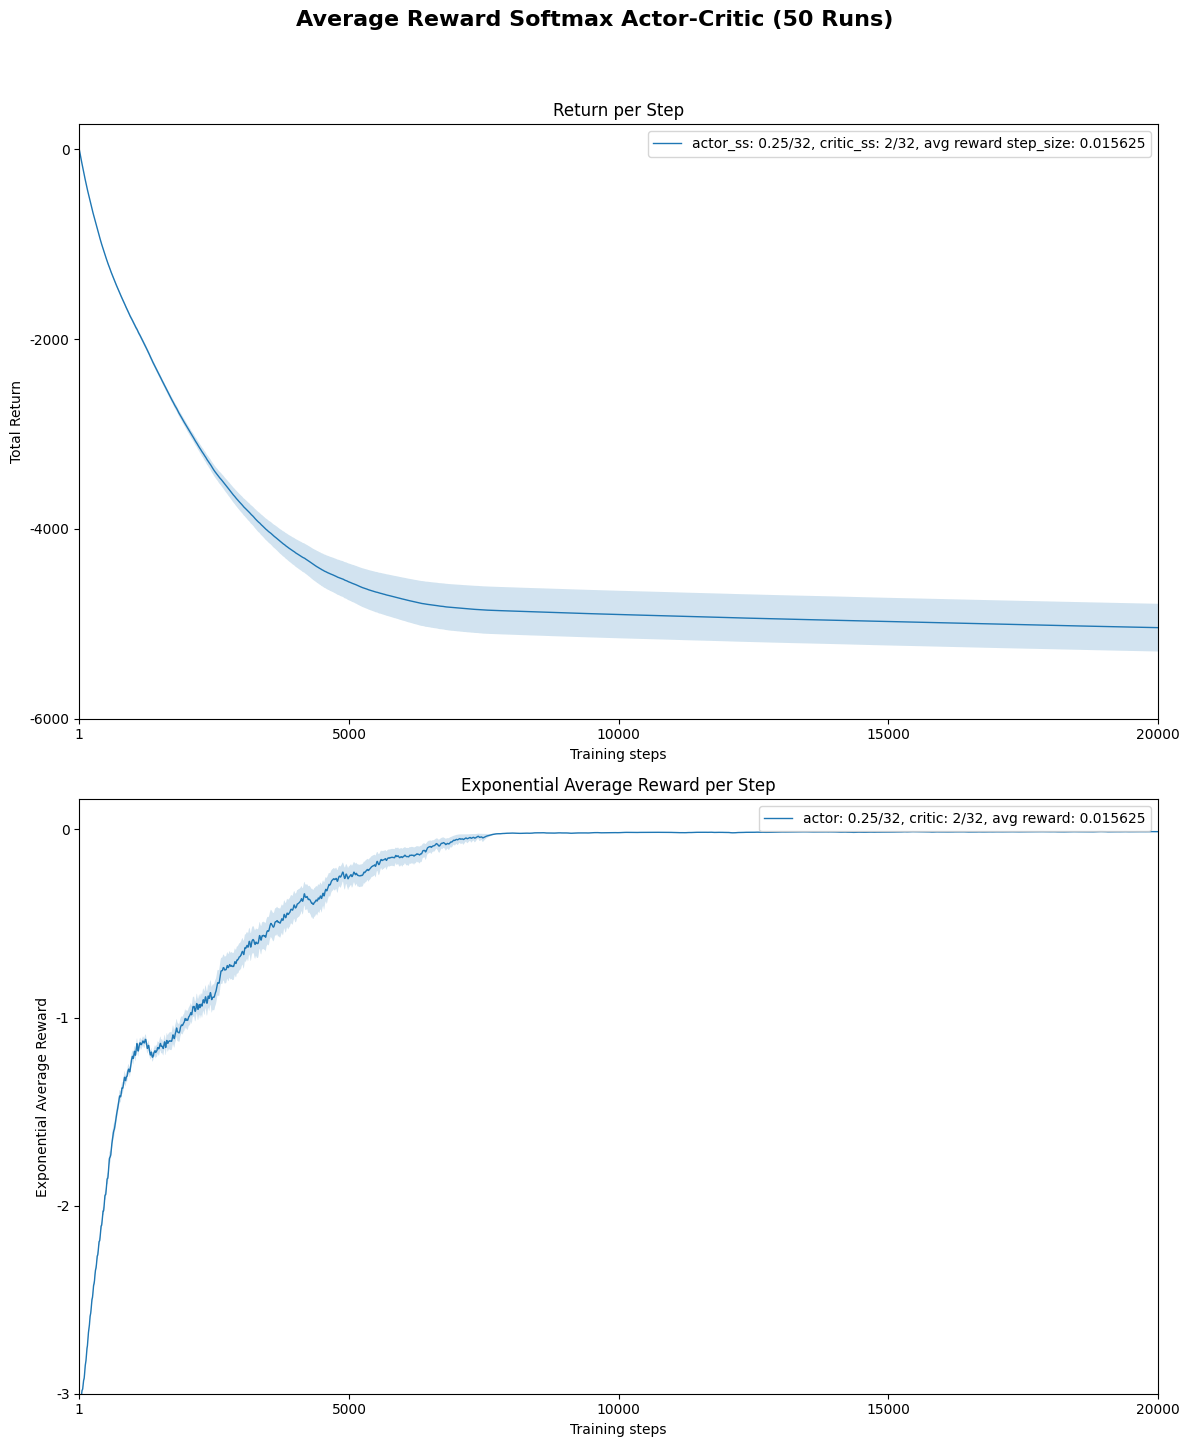

In [ ]:
#### Run Experiment

# Experiment parameters
experiment_parameters = {
    "max_steps" : 20000,
    "num_runs" : 50
}

# Environment parameters
environment_parameters = {}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
# actor and critic step-sizes are divided by num. tilings inside the agent
agent_parameters = {
    "num_tilings": [32],
    "num_tiles": [8],
    "actor_step_size": [2**(-2)],
    "critic_step_size": [2**1],
    "avg_reward_step_size": [2**(-6)],
    "num_actions": 3,
    "iht_size": 4096
}

current_env = PendulumEnvironment
current_agent = ActorCriticSoftmaxAgent


run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')

Run the following code to verify your experimental result.

In [ ]:
## Test Code for experimental result ##
filename = 'ActorCriticSoftmax_tilings_32_tiledim_8_actor_ss_0.25_critic_ss_2_avg_reward_ss_0.015625_exp_avg_reward'
agent_exp_avg_reward = np.load('results/{}.npy'.format(filename), allow_pickle=True)
result_med = np.median(agent_exp_avg_reward, axis=0)

answer_range = np.load('/content/exp_avg_reward_answer_range.npy', allow_pickle=True)
upper_bound = answer_range.item()['upper-bound']
lower_bound = answer_range.item()['lower-bound']

# check if result is within answer range
all_correct = np.all(result_med <= upper_bound) and np.all(result_med >= lower_bound)

if all_correct:
    print("Your experiment results are correct!")
else:
    print("Your experiment results does not match with ours. Please check if you have implemented all methods correctly.")

Your experiment results are correct!


## Section 3-2: Performance Metric and Meta-Parameter Sweeps


### Performance Metric

To evaluate performance, we plotted both the return and exponentially weighted average reward over time.

In the first plot, the return is negative because the reward is negative at every state except when the pendulum is in the upright position. As the policy improves over time, the agent accumulates less negative reward, and thus the return decreases slowly. Towards the end the slope is almost flat indicating the policy has stabilized to a good policy. When using this plot however, it can be difficult to distinguish whether it has learned an optimal policy. The near-optimal policy in this Pendulum Swing-up Environment is to maintain the pendulum in the upright position indefinitely, getting near 0 reward at each time step. We would have to examine the slope of the curve but it can be hard to compare the slope of different curves.

The second plot using exponential average reward gives a better visualization. We can see that towards the end the value is near 0, indicating it is getting near 0 reward at each time step. Here, the exponentially weighted average reward shouldn't be confused with the agent’s internal estimate of the average reward. To be more specific, we used an exponentially weighted average of the actual reward without initial bias (Refer to Exercise 2.7 from the textbook (p.35) to read more about removing the initial bias). If we used sample averages instead, later rewards would have decreasing impact on the average and would not be able to represent the agent's performance with respect to its current policy effectively.

It is easier to see whether the agent has learned a good policy in the second plot than the first plot. If the learned policy is optimal, the exponential average reward would be close to 0.

Furthermore, how did we pick the best meta-parameter from the sweeps? A common method would be to pick the meta-parameter that results in the largest Area Under the Curve (AUC). However, this is not always what we want. We want to find a set of meta-parameters that learns a good final policy. When using AUC as the criteria, we may pick meta-parameters that allows the agent to learn fast but converge to a worse policy. In our case, we selected the meta-parameter setting that obtained the most exponential average reward over the last 5000 time steps.


### Parameter Sensitivity

In addition to finding the best meta-parameters it is also equally important to plot **parameter sensitivity curves** to understand how our algorithm behaves.

In our simulated Pendulum problem, we can extensively test our agent with different meta-parameter configurations but it would be quite expensive to do so in real life. Parameter sensitivity curves can provide us insight into how our algorithms might behave in general. It can help us identify a good range of each meta-parameters as well as how sensitive the performance is with respect to each meta-parameter.

Here are the sensitivity curves for the three step-sizes we swept over:

<img src="data/sensitivity_combined.png" alt="Drawing" style="width: 1000px;"/>

On the y-axis we use the performance measure, which is the average of the exponential average reward over the 5000 time steps, averaged over 50 different runs. On the x-axis is the meta-parameter we are testing. For the given meta-parameter, the remaining meta-parameters are chosen such that it obtains the best performance.

The curves are quite rounded, indicating the agent performs well for these wide range of values. It indicates that the agent is not too sensitive to these meta-parameters. Furthermore, looking at the y-axis values we can observe that average reward step-size is particularly less sensitive than actor step-size and critic step-size.

But how do we know that we have sufficiently covered a wide range of meta-parameters? It is important that the best value is not on the edge but in the middle of the meta-parameter sweep range in these sensitivity curves. Otherwise this may indicate that there could be better meta-parameter values that we did not sweep over.

## Wrapping up

### **Congratulations!** You have successfully implemented Course 3 Programming Assignment 4.


You have implemented your own **Average Reward Actor-Critic with Softmax Policy** agent in the Pendulum Swing-up Environment. You implemented the environment based on information about the state/action space and transition dynamics. Furthermore, you have learned how to implement an agent in a continuing task using the average reward formulation. We parameterized the policy using softmax of action-preferences over discrete action spaces, and used Actor-Critic to learn the policy.


To summarize, you have learned how to:
    1. Implement softmax actor-critic agent on a continuing task using the average reward formulation.
    2. Understand how to parameterize the policy as a function to learn, in a discrete action environment.
    3. Understand how to (approximately) sample the gradient of this objective to update the actor.
    4. Understand how to update the critic using differential TD error.